In [1]:
# Render our plots inline
%matplotlib inline
%pylab inline  
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# General Plotting Parameters
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 14.
mpl.rcParams['legend.fontsize'] = 12.
mpl.rcParams['axes.labelsize'] = 12.
mpl.rcParams['xtick.labelsize'] = 10.
mpl.rcParams['ytick.labelsize'] = 10.
mpl.rcParams['xtick.minor.pad'] = 4
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

#Git says this is patched, but it doesn't work from Pip --upgrade 26-mar-2015
#mpl.rcParams['xtick.minor.visible'] = True  

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14),
             (255, 187, 120), (44, 160, 44), (152, 223, 138),
              (148, 103, 189),
             (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127),
             (199, 199, 199), (188, 189, 34), (219, 219, 141),
             (23, 190, 207), (158, 218, 229),(214, 39, 40), (255, 152, 150)]  
    
# Scale the RGB values to the [0, 1] range,
# which is the format matplotlib accepts.  
for i in range(len(tableau20)): 
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  


Populating the interactive namespace from numpy and matplotlib


In [2]:
import hist_bench
reload(hist_bench)
import gen_fns
reload(gen_fns)
from gen_fns import get_data
from gen_fns import ls_fit
from hist_bench import calc_pursuit
from hist_bench import get_pes
from hist_bench import calc_weights

bin_edges = [0,1,2,3,4,5,6,7,8,9,10]

In [3]:
#path = "/Users/mbmcgarry/git/data_analysis/data/v1.3/multi_lat/"
#file = "44_state.tsv"

path = "/Users/mbmcgarry/git/historical_prolif/"
file = "historical_factors.csv"

factor_weights = calc_weights(path+file)
print factor_weights

#factor_weights = np.array([0.15, 0.1, 0.16, 0.09, 0.1,0.1, 0.15, 0.15])

countries, col_names, all_vals = get_data(path+file, n_header=1, col_list=range(2,11))
status = all_vals[:,0]
raw_data = np.delete(all_vals, 0, 1)

[ 0.12  0.08  0.18  0.1   0.05  0.21  0.26  0.  ]


In [4]:
all_pe_vals = calc_pursuit(raw_data, factor_weights)
pursue_states, pursue_pes = get_pes(countries, all_pe_vals, "Pursue")
prolif_states, prolif_pes = get_pes(countries, all_pe_vals, "Prolif")

pursue_hist, edges_pur = np.histogram(pursue_pes,bins=bin_edges)
prolif_hist, edges_pro = np.histogram(prolif_pes,bins=bin_edges)
all_hist, edges_a = np.histogram(all_pe_vals, bins=bin_edges)


In [5]:
frac_pursue=np.nan_to_num(pursue_hist.astype(float)/all_hist.astype(float))
frac_prolif=np.nan_to_num(prolif_hist.astype(float)/all_hist.astype(float))
prolif_pursue=np.nan_to_num(prolif_hist.astype(float)/pursue_hist.astype(float))

denom_pursue = np.full(len(pursue_hist),pursue_hist.sum()) 
frac_pursue_weight = pursue_hist/denom_pursue

denom_succ = np.full(len(prolif_pursue),prolif_pursue.sum()) 
frac_succ_weight = prolif_pursue/denom_succ

weights  [ 0.    0.    0.    0.04  0.08  0.12  0.46  0.12  0.17  0.  ]


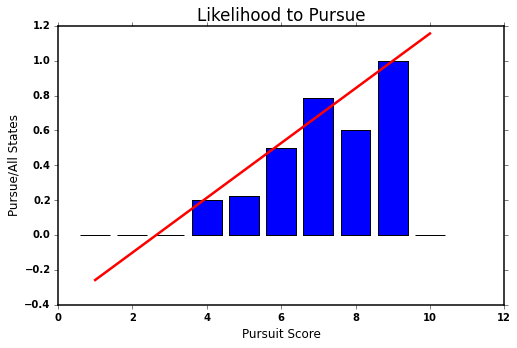

In [6]:
barwidth=0.8
index = np.delete(bin_edges,-1) + (1-barwidth)
xvals = np.arange(1,11)
int_pursue, m_pursue = ls_fit(xvals, frac_pursue, frac_pursue_weight)

plt.bar(index+(barwidth/2), frac_pursue, barwidth)
plt.plot(xvals, m_pursue*xvals + int_pursue, color = 'red')

plt.title("Likelihood to Pursue")
plt.xlabel("Pursuit Score")
plt.ylabel("Pursue/All States")


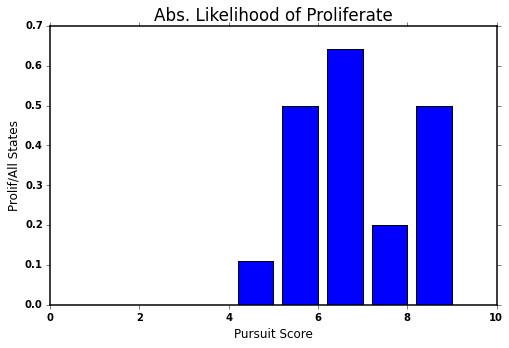

In [7]:
barwidth=0.8
plt.bar(index, frac_prolif, barwidth)

plt.title("Abs. Likelihood of Proliferate")
plt.xlabel("Pursuit Score")
plt.ylabel("Prolif/All States")


weights  [ 0.    0.    0.    0.    0.16  0.32  0.26  0.11  0.16  0.  ]


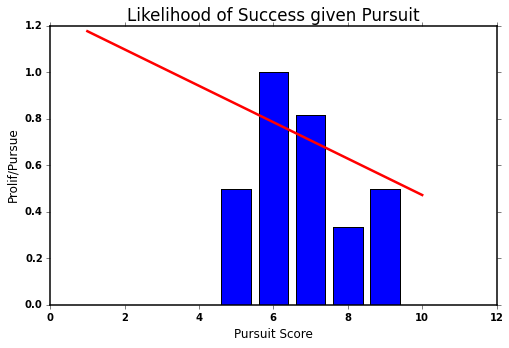

In [8]:
barwidth=0.8

int_succ, m_succ = ls_fit(xvals, prolif_pursue, frac_succ_weight)

plt.bar(index+(barwidth/2), prolif_pursue, barwidth)
plt.plot(xvals, m_succ*xvals + int_succ, color = 'red')

plt.title("Likelihood of Success given Pursuit")
plt.xlabel("Pursuit Score")
plt.ylabel("Prolif/Pursue")



In [9]:
# Time to acquire. States that never succeeded have negative years in the database, set them all to 30yrs
# (longest time to successfully acquire was 26yrs, all failed attempts were greater than 30yrs from 2015
# except Syria (15yrs) 

from hist_bench import time_to_acquire

# returns time to acquire for all states that have attempted pursuit
acq_times = time_to_acquire()

pursuit_scores = []
corr_acq_times = []


for idx, cur_state in enumerate(countries):
    if (cur_state in acq_times) and (status[idx] == 2):
        cur_time = acq_times[cur_state]
        if (cur_time >= 0):
            corr_acq_times.append(cur_time)
            pursuit_scores.append(all_pe_vals[idx])
            print "State ",cur_state, " Score ", all_pe_vals[idx], " Time ", cur_time
#        To look at the distribution of countries that pursued but never acquired
#        else:
#            corr_acq_times.append(-1*cur_time)
#            pursuit_scores.append(all_pe_vals[idx])
#            print "State ",cur_state, " Score ", all_pe_vals[idx], " Time ", cur_time


int_time, m_time = ls_fit(np.asarray(pursuit_scores), np.asarray(corr_acq_times))


State  US  Score  6.4872  Time  3
State  USSR  Score  8.859  Time  4
State  UK  Score  5.8464  Time  5
State  France  Score  6.7933  Time  6
State  China  Score  6.3277  Time  9
State  Israel  Score  6.1962  Time  9
State  India  Score  6.4368  Time  24
State  Pakist  Score  5.2904  Time  15
weights  [ 1.  1.  1.  1.  1.  1.  1.  1.]


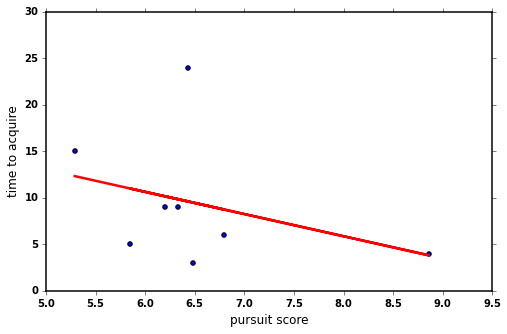

In [10]:
plt.scatter(pursuit_scores, corr_acq_times)
plt.xlabel('pursuit score')
plt.ylabel('time to acquire')
plt.plot(pursuit_scores, m_time*np.asarray(pursuit_scores) + int_time, color = 'red')

In [11]:
# NOT WORKING

# Linear Fit
import scipy as sp
from gen_fns import fit_exp_linear

C0 = 20
# Linear Fit (Note that we have to provide the y-offset ("C") value!!
A, K = fit_exp_linear(np.asarray(pursuit_scores), np.asarray(corr_acq_times), C0)
fit_y= A * np.exp(K * np.asarray(pursuit_scores)) + C0

